<a href="https://colab.research.google.com/github/elironbarel/Deep-Learning-Final-Project/blob/main/Final_project_Eliron_Barel_Ohad_Maymon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project topic: Identifying a specific dog based on images of the same dog from various angles and at different ages.

## Download and load dataset

**context:**

The Stanford Dogs dataset contains 20,580 images of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, our challenging problem of identify a certain dog will use this dataset.

In [ ]:
# Download data directly from Kaggle (1)
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Upload the dataset & unzip the files
! kaggle datasets download -d jessicali9530/stanford-dogs-dataset
! unzip stanford-dogs-dataset
!pip install pillow pyheif

# mount Google Drive (1)
from google.colab import drive
drive.mount('/content/drive')

# import proper libraries (2)
import os
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import shutil
from PIL import Image, UnidentifiedImageError
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pyheif

# move to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
specific_dog_dir = "/content/drive/MyDrive/FinalProjectData/Romeo_Dir/" # Path to your specific dog's images
augmented_dir = "/content/drive/MyDrive/FinalProjectData/augmented_dir2/"  # Directory to save augmented images
data_dir = "/content/drive/MyDrive/FinalProjectData/all_dogs_images/" # Directory to save all dogs images

Mounted at /content/drive
Using device: cpu


The original data base was catacorized to 120 differnt breads heance 120 folders.

In this code I moved all the images to one all_dogs_images folder.

In [ ]:
# Go on all the dog folders and copying the pictures
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):  # Only images
            source_path = os.path.join(root, file)
            destination_path = os.path.join(destination_folder, file)

            # If there is a duplicate file name, add a number to the end of the name.
            counter = 1
            while os.path.exists(destination_path):
                name, ext = os.path.splitext(file)
                destination_path = os.path.join(destination_folder, f"{name}_{counter}{ext}")
                counter += 1

            shutil.copy2(source_path, destination_path)

# Ensure augmented directory exists
os.makedirs(augmented_dir, exist_ok=True)

Creating the data frame of class 1: Romeo images and augmented images of Romeo.
class 0: All other dogs images

Data Augmentation:
Apply transformations such as random horizontal flips, rotations, or color jitter to increase dataset variability.

In [ ]:
# Step 1: Collect and Label Data
all_data = []

# Label specific dog as 1
for img in os.listdir(specific_dog_dir):
    all_data.append((os.path.join(specific_dog_dir, img), 1))

# Label other dogs images as 0
for img in os.listdir(data_dir):
    img_path = os.path.join(data_dir, img)
    all_data.append((img_path, 0))

# Create a DataFrame
df = pd.DataFrame(all_data, columns=['filepath', 'label'])

# Step 2: Augment Specific Dog Images
def augment_images(image_paths, save_dir, augment_count=20):
    """
    Augment images for balancing and save to the specified directory.
    """
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    for img_path in tqdm(image_paths, desc="Augmenting Images"):
        try:
            img = Image.open(img_path)  # Load image using PIL

            # Convert RGBA to RGB if necessary
            if img.mode == 'RGBA':
                img = img.convert('RGB')  # Convert RGBA to RGB

            img_array = img_to_array(img)  # Convert to array
            img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for generator

            # Generate augmented images
            for i, batch in enumerate(datagen.flow(img_array, batch_size=1,
                                                   save_to_dir=save_dir,
                                                   save_prefix="augmented",
                                                   save_format="jpg")):
                if i >= augment_count - 1:  # Stop after generating augment_count images
                    break
        except UnidentifiedImageError:
            print(f"Skipping corrupted or unidentifiable image: {img_path}")
            continue
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            continue

# Augment your specific dog's images
specific_dog_images = [os.path.join(specific_dog_dir, img) for img in os.listdir(specific_dog_dir)]
augment_images(specific_dog_images, save_dir=augmented_dir)

# Step 3: Add Augmented Images to DataFrame
for img in os.listdir(augmented_dir):
    all_data.append((os.path.join(augmented_dir, img), 1))

# Step 4: Create Updated DataFrame and Balance Classes
df = pd.DataFrame(all_data, columns=['filepath', 'label'])

# Check class balance
class_counts = df['label'].value_counts()
print("Class counts before balancing:", class_counts)

# Balance classes (if still imbalanced, you may oversample)
minority_class = df[df['label'] == 1]
majority_class = df[df['label'] == 0].sample(n=len(minority_class), random_state=42)

balanced_df = pd.concat([minority_class, majority_class]).sample(frac=1, random_state=42)

# Step 5: Split into Train/Test Sets
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['label'], random_state=42)

print(f"Training samples: {len(train_df)}, Testing samples: {len(test_df)}")

Class counts before balancing: label
0    20580
1     2526
Name: count, dtype: int64
Training samples: 4041, Testing samples: 1011


# Preprocessing
* Resizing: Resize all images to a fixed size (e.g., 150x150 for CNNs).
* Normalization: Normalize pixel values to range [0, 1] or standardize using the dataset mean and standard deviation.
* Augmentation: Use augmentations (rotation, color jitter, etc.) to make the model robust to variations.

In [ ]:
# Custom Dataset Class to Load Images from DataFrame
class DogDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Filepath
        label = self.dataframe.iloc[idx, 1]  # Label

        try:
            if img_path.lower().endswith('.heic'):  # Convert HEIC to RGB
                heif_file = pyheif.read(img_path)
                image = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
            else:
                image = Image.open(img_path).convert("RGB")  # Ensure RGB format

            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.float32)

        except Exception as e:
            print(f"Skipping corrupted or unidentifiable image: {img_path} - {e}")
            return None  # Return None for failed images

# Filter out None values when creating DataLoader
def collate_fn(batch):
    batch = [b for b in batch if b is not None]  # Remove None values
    if len(batch) == 0:
        return None  # Handle empty batch case
    return torch.utils.data.default_collate(batch)

# Define transformations for Train and Test sets
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset instances
train_dataset = DogDataset(train_df, transform=train_transform)
test_dataset = DogDataset(test_df, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, pin_memory=True, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Debugging: Check dataset sizes
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(test_loader.dataset)}")

Training dataset size: 4041
Validation dataset size: 1011


# Model building

Our CNN model incorporating the key components discussed in the course:
* Convolutional layers
* Pooling layers
* Activation functions (e.g., ReLU)
* Fully connected layers
* Dropout layers to prevent overfitting

Our CNN model takes an input of 3×150×150 (3 RGB channels and images of size 150×150).

The network consists of **two convolutional layers**, each with a 3×3 **kernel, stride of 1, and padding of 1**. The number of channels increases through the layers:
**(3 → 16 → 32)**, allowing the network to learn increasingly complex features.

After each convolutional layer, we apply max pooling (2×2) to reduce spatial dimensions by half, ensuring efficient feature extraction.

Between layers, we use **ReLU activation**, which introduces non-linearity to the model and helps capture complex patterns.

Once the final convolutional layer processes the image, we **flatten the feature maps into a vector**, preparing them for the fully connected layers.

The model includes **two fully connected layers**:

1. **FC1**: Maps the flattened features to **256 neurons**, followed by a **ReLU activation** and **dropout (30%)** to prevent overfitting.
2. **FC2**: Maps the 256 neurons to a **single output neuron** representing the probability of the input image belonging to the target class.

Since this is a **binary classification task**, we use the sigmoid activation function in the final layer to output a probability between 0 and 1.

The class prediction is determined by applying a **threshold of 0.5**—if the output probability is ≥**0.5, the image belongs to the target class**; otherwise, it belongs to the other category.

In [ ]:
class CNN(nn.Module):
    def __init__(self, dropout=0.3):
        # convolution layers
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1)

        # max pool
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        #flatten and fully connected
        self.fc1 = nn.Linear(32*37*37, 256)
        self.fc2 = nn.Linear(256, 1) # Binary classification

        #dropout
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()  # Sigmoid for binary classification

    def forward(self, x):
        # conv layers
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 37 * 37)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x)) # Apply sigmoid
        return x

#calculations for number of parameters in each layer (b)
  #First conv info
conv1_out_channels = 16
conv1_kernel_size = 3
conv1_in_channels = 3
conv1_biases = conv1_out_channels
  #First conv claculations
conv1_weights = conv1_out_channels * conv1_in_channels * conv1_kernel_size * conv1_kernel_size
conv1_total_weights = conv1_weights + conv1_biases

  #Second conv info
conv2_out_channels = 32
conv2_kernel_size = 3
conv2_in_channels = 16
conv2_biases = conv2_out_channels
  #Second conv calculations
conv2_weights= conv1_out_channels * conv2_in_channels * conv2_kernel_size * conv2_kernel_size
conv2_total_weights = conv2_weights + conv2_biases


  #FC1 info
fc1_in_features = 32 * 37 * 37
fc1_out_features = 256
fc1_biases = fc1_out_features
  #FC1 calculations
fc1_weights = fc1_in_features * fc1_out_features
fc1_total_weights = fc1_weights + fc1_biases

  #FC2 info
fc2_in_features = 256
fc2_out_features = 6
fc2_biases = fc2_out_features

  #FC2 calculations
fc2_weights = fc2_in_features * fc2_out_features
fc2_total_weights = fc2_weights + fc2_biases

#total weights for network
total_weights = conv1_total_weights + conv2_total_weights + fc1_total_weights + fc2_total_weights
# Results
weights = {
    "Conv1 Weights": conv1_total_weights,
    "Conv2 Weights": conv2_total_weights,
    "FC1 Weights": fc1_total_weights,
    "FC2 Weights": fc2_total_weights,
    "Total Weights": total_weights
}
print(f"Weights: {weights}")

Weights: {'Conv1 Weights': 448, 'Conv2 Weights': 2336, 'FC1 Weights': 11215104, 'FC2 Weights': 1542, 'Total Weights': 11219430}


# Visualizing Features Maps and Filters

1. visualize_filters(layer): This function displays the learned filters (kernels) from a CNN layer. Filters detect patterns like edges and textures, and visualizing them helps understand what features the model is learning.

2. visualize_feature_maps(image, model): This function shows how an image is processed by a convolutional layer, highlighting activated regions. It helps visualize which parts of the image the CNN focuses on, revealing learned patterns at different layers.

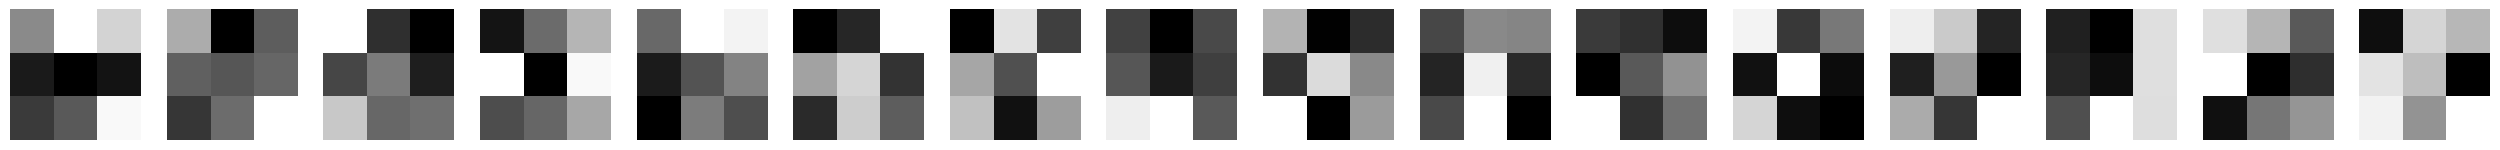

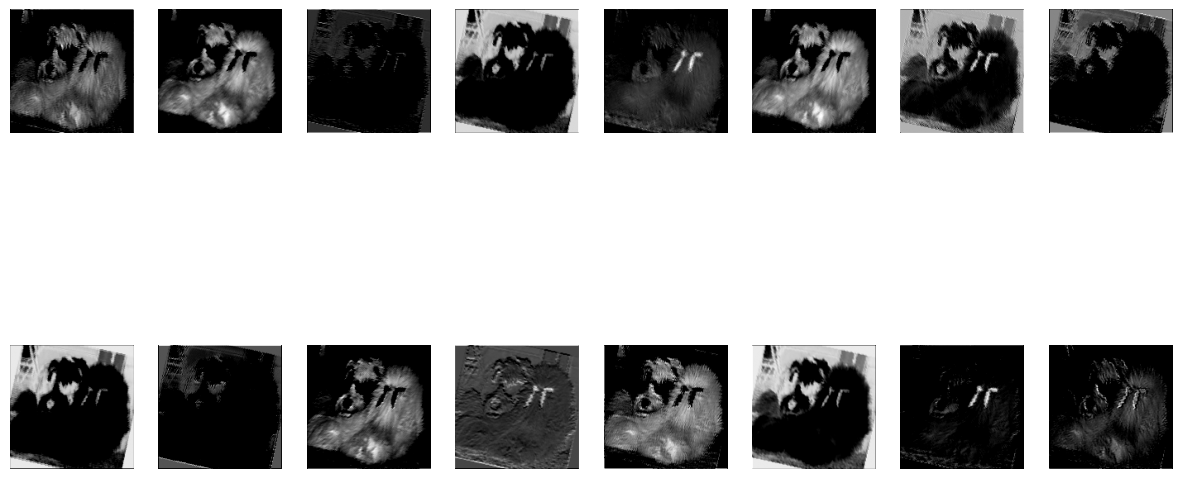

In [ ]:
def visualize_filters(layer):
    filters = layer.weight.data.clone().cpu()  # Move to CPU for visualization
    filters = filters - filters.min()  # Normalize
    filters = filters / filters.max()

    num_filters = filters.shape[0]  # Number of output filters
    fig, axs = plt.subplots(1, num_filters, figsize=(num_filters * 2, 2))

    for i in range(num_filters):
        filter_img = filters[i, 0].numpy()  # Take only the first channel

        axs[i].imshow(filter_img, cmap='gray')  # Convert to grayscale image
        axs[i].axis('off')

    plt.show()

# Visualize the filters of the first convolutional layer
model = CNN()
visualize_filters(model.conv1)

def visualize_feature_maps(image, model):
    x = image.unsqueeze(0)
    x = model.conv1(x)
    x = torch.relu(x)
    feature_maps = x.detach().squeeze(0)
    num_maps = feature_maps.shape[0]
    n_columns = 8
    n_rows = num_maps // n_columns + (num_maps % n_columns > 0)
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
    for i in range(num_maps):
        row = i // n_columns
        col = i % n_columns
        axs[row, col].imshow(feature_maps[i].numpy(), cmap='gray')
        axs[row, col].axis('off')
    plt.show()

# Visualize feature maps for a single image
sample_image, _ = train_dataset[0]
visualize_feature_maps(sample_image, model)

# Training

**Training Process Overview:**
1. **Hyperparameters**

* Learning Rate (0.001): Controls weight updates to balance learning speed and stability.
* Batch Size (32): Number of images processed before updating model weights.
* Epochs (7): Full dataset passes to refine model performance.
2. **Optimizer & Loss Function**

* Optimizer (Adam): Efficiently adjusts weights using adaptive learning rates.
* Loss Function (BCELoss): Measures the error in binary classification tasks.
3. **Training Loop**

* Forward Pass: Sends images through the model to compute predictions.
* Loss Calculation: Compares predictions to true labels.
* Backward Pass (Gradient Descent): Adjusts weights to minimize loss.
* Validation Step: Evaluates performance on unseen data.
4. **Learning Rate Scheduling**

* No explicit scheduler used, but Adam dynamically adjusts learning rates per parameter for stable learning.

Using device: cpu


100%|██████████| 32/32 [06:55<00:00, 12.97s/it]


Epoch 1/10, Train Loss: 0.6482, Val Loss: 0.4675


100%|██████████| 32/32 [03:06<00:00,  5.82s/it]


Epoch 2/10, Train Loss: 0.4267, Val Loss: 0.3610


100%|██████████| 32/32 [02:58<00:00,  5.59s/it]


Epoch 3/10, Train Loss: 0.3412, Val Loss: 0.3431


100%|██████████| 32/32 [02:56<00:00,  5.52s/it]


Epoch 4/10, Train Loss: 0.2945, Val Loss: 0.2463


100%|██████████| 32/32 [03:02<00:00,  5.71s/it]


Epoch 5/10, Train Loss: 0.2406, Val Loss: 0.1957


100%|██████████| 32/32 [03:00<00:00,  5.64s/it]


Epoch 6/10, Train Loss: 0.2228, Val Loss: 0.2163


100%|██████████| 32/32 [02:56<00:00,  5.52s/it]


Epoch 7/10, Train Loss: 0.1982, Val Loss: 0.1623


100%|██████████| 32/32 [03:04<00:00,  5.76s/it]


Epoch 8/10, Train Loss: 0.1766, Val Loss: 0.1896


100%|██████████| 32/32 [03:01<00:00,  5.68s/it]


Epoch 9/10, Train Loss: 0.1545, Val Loss: 0.1523


100%|██████████| 32/32 [02:57<00:00,  5.53s/it]


Epoch 10/10, Train Loss: 0.1373, Val Loss: 0.1262


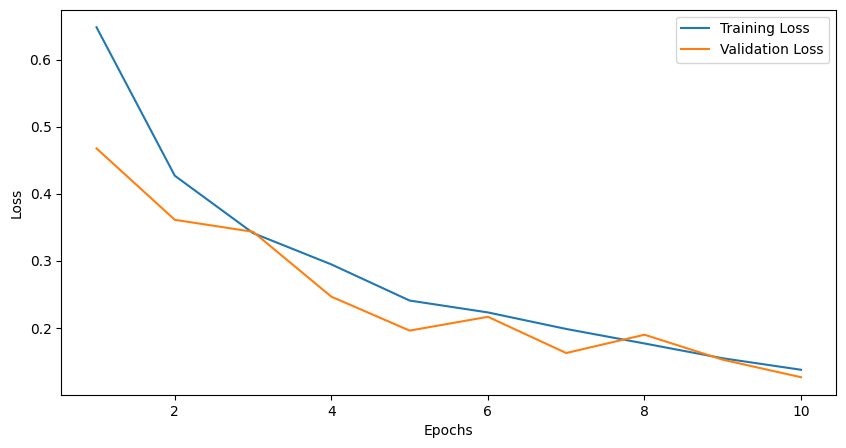

✅ Model saved successfully at /content/drive/MyDrive/FinalProjectData/model_10epoch_weights.pth


In [ ]:
# move to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = CNN().to(device)

#set hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 10

#optimizer and loss functions
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device).float()  # Ensure labels are float
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device).float()  # Ensure labels are float
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
    val_loss = val_loss / len(test_loader)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

#plot train and validation loss
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

save_path = "/content/drive/MyDrive/FinalProjectData/model_10epoch_weights.pth"
torch.save(model.state_dict(), save_path)  # Save model weights
print(f"✅ Model saved successfully at {save_path}")

# load_path = "/content/drive/MyDrive/FinalProjectData/model_weights.pth"

# model = CNN()  # Reinitialize model
# model.load_state_dict(torch.load(load_path))  # Load saved weights
# model.to(device)
# print("✅ Model loaded successfully from Google Drive!")

# Evaluation/Testing

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Test the model
correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()  # Ensure binary predictions (0 or 1)

        correct += (predicted == labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # Count total samples

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Total samples: {total}, Correct predictions: {correct}")
accuracy = (correct / total) * 100
print(f"Test Accuracy: {accuracy:.2f}%")
# Classification report for precision, recall, and F1-score
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Not Romeo', 'Romeo']))

Total samples: 1011, Correct predictions: 961
Test Accuracy: 95.05%
Classification Report:
              precision    recall  f1-score   support

   Not Romeo       0.96      0.94      0.95       506
       Romeo       0.94      0.96      0.95       505

    accuracy                           0.95      1011
   macro avg       0.95      0.95      0.95      1011
weighted avg       0.95      0.95      0.95      1011



# Confusion Matrix

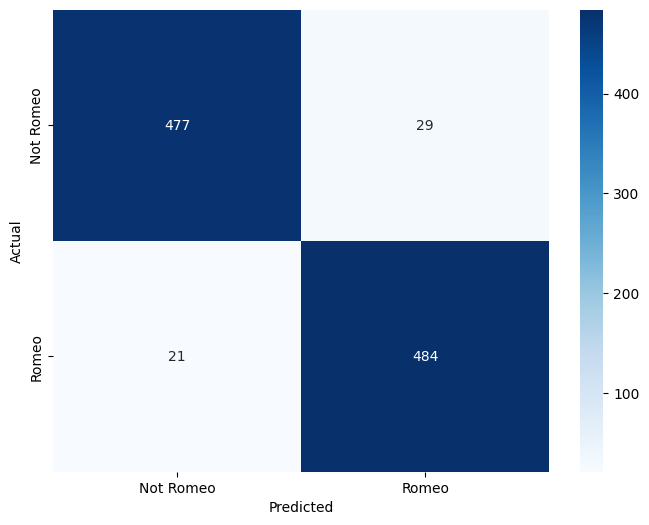

In [ ]:
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Romeo', 'Romeo'], yticklabels=['Not Romeo', 'Romeo'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#  Visualization

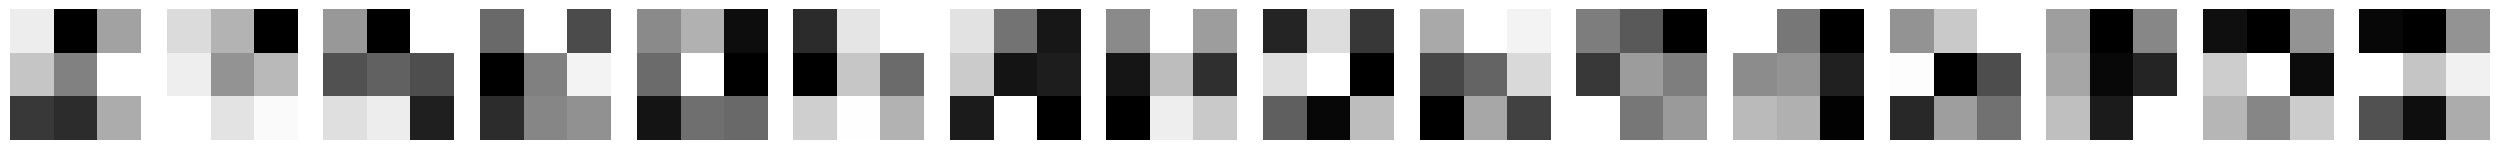

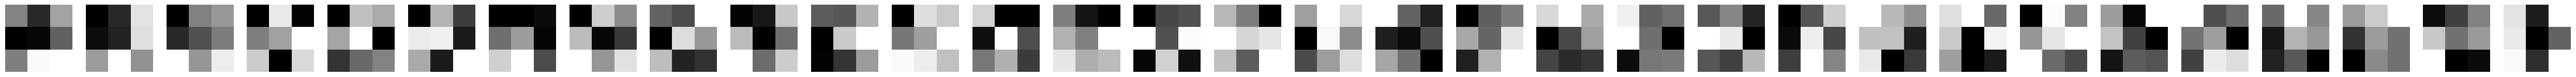

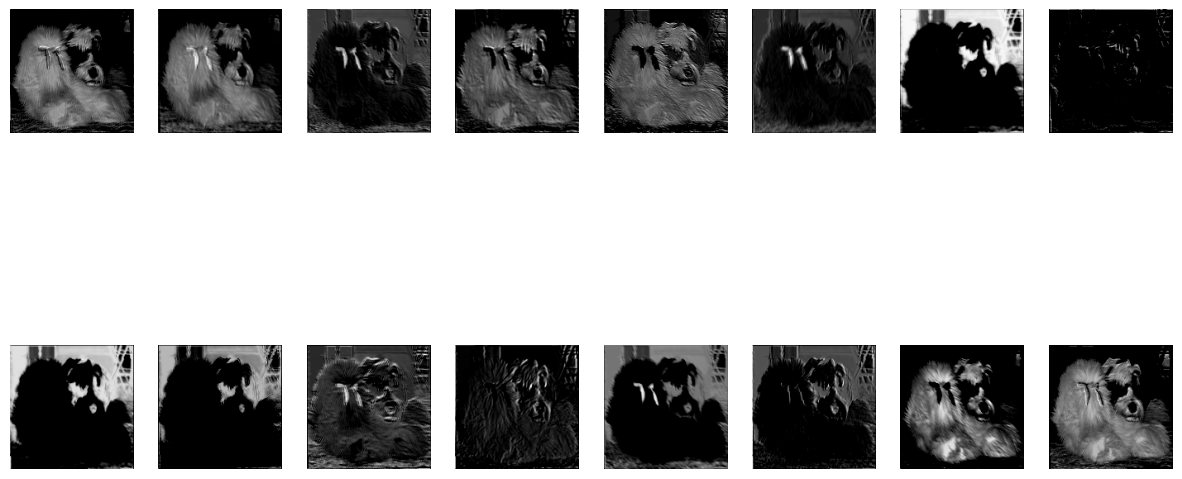

In [ ]:
#Visual of filters of layers
model.to("cpu")
#first layer
visualize_filters(model.conv1)
#second layer
visualize_filters(model.conv2)

#Feature maps (a.2)
def visualize_filters(layer):
    filters = layer.weight.data.clone()  # Get filter weights
    filters = filters - filters.min()  # Normalize
    filters = filters / filters.max()

    num_filters = filters.shape[0]  # Number of filters (out_channels)

    fig, axs = plt.subplots(1, num_filters, figsize=(num_filters * 2, 2))

    for i in range(num_filters):
        filter_img = filters[i, 0].cpu().numpy()  # Take first input channel

        axs[i].imshow(filter_img, cmap='gray')  # Convert to grayscale image
        axs[i].axis('off')

    plt.show()


# Visualize feature maps for a single image
sample_image, _ = train_dataset[0]
visualize_feature_maps(sample_image, model)

# Training Curves

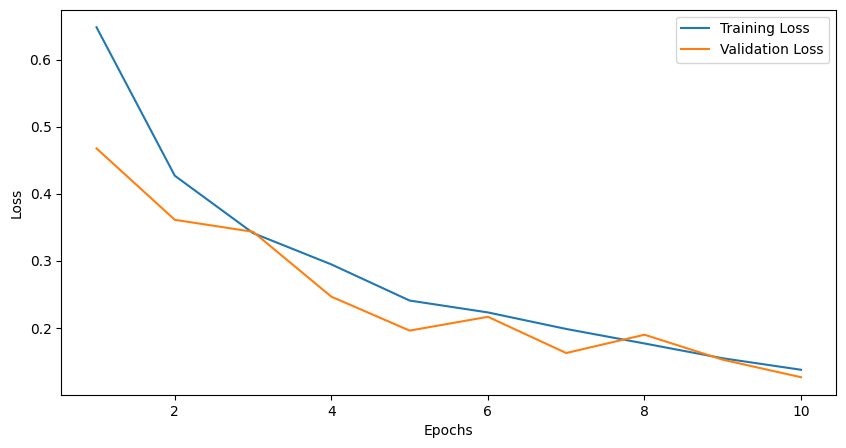

In [ ]:
#visual of training and validation loss curve
#plot train and validation loss
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#  Hyperparameter Tuning

the result of training with 7 epoch:
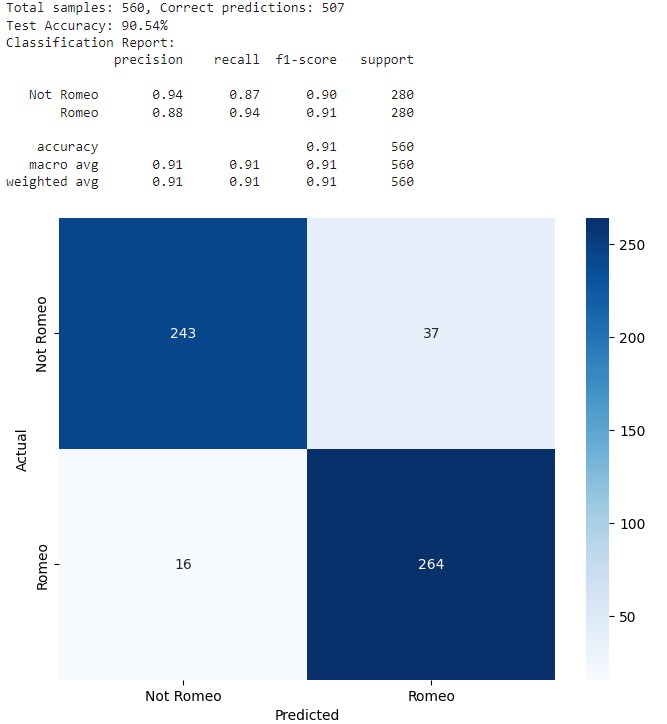

1. we changed our number of epochs from 7 --> 10 and the result were:
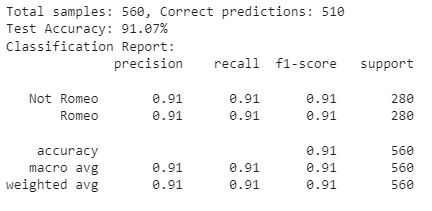
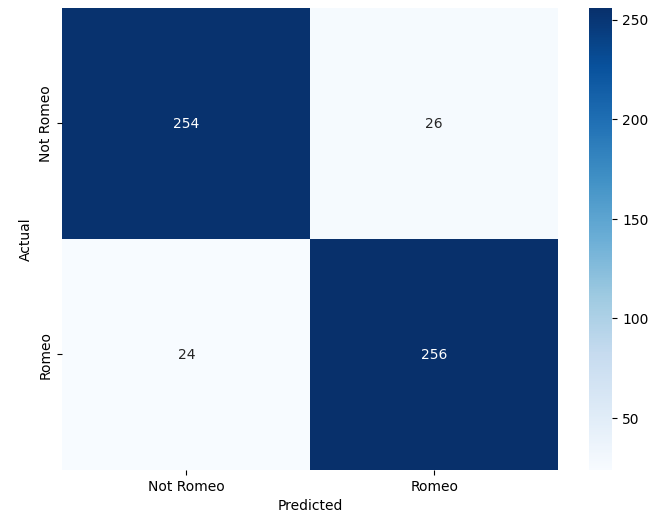
2. we changed our number of epochs from 7 --> 5 and the result were: 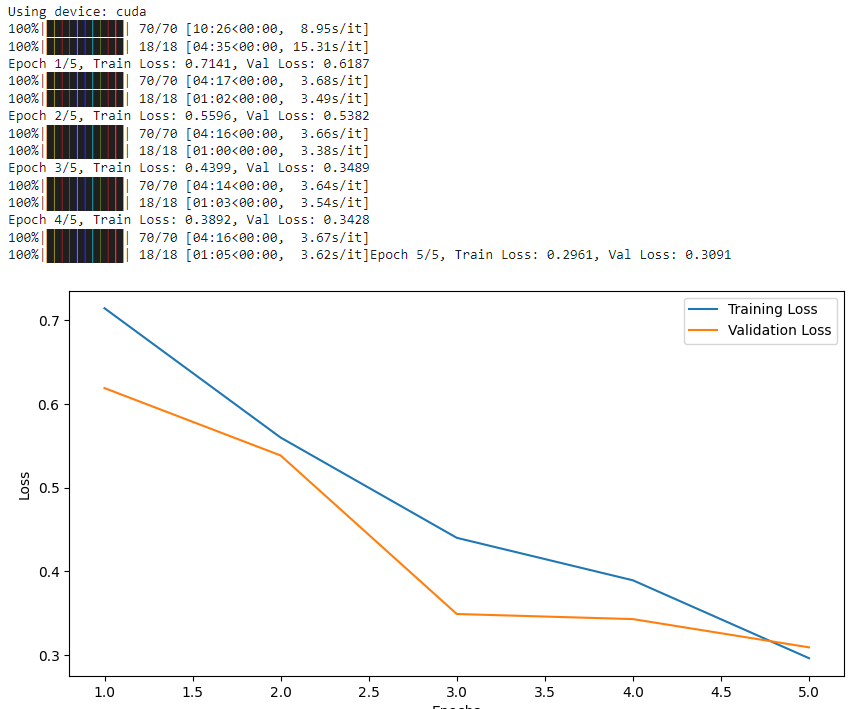
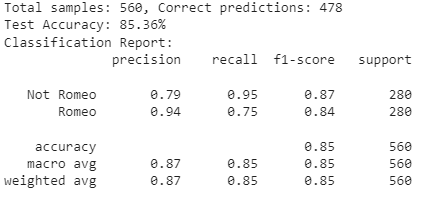
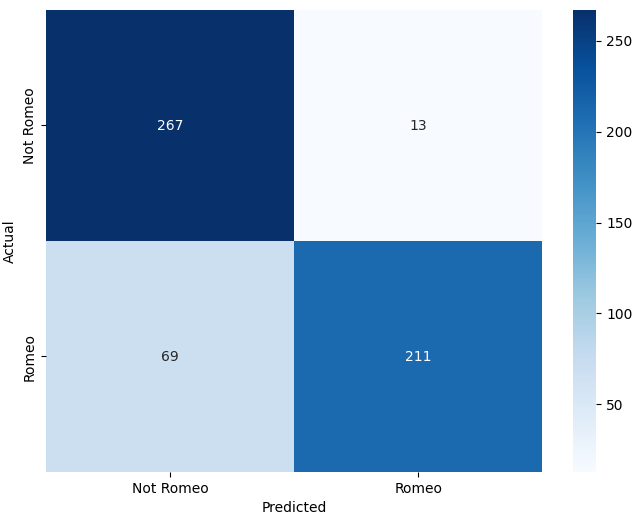

# Facing Dataset Imbalance issue:

We saw that we are getting up to maximum 91.07 accuracy and we wanted to improve it by adding more images of Romeo to Romeo_Dir, so we doubled the amount of Romeo images and got a bigger augmented file and from that a better accuracy overall, we manage to get to 95.05% accuracy which is a big improvment.

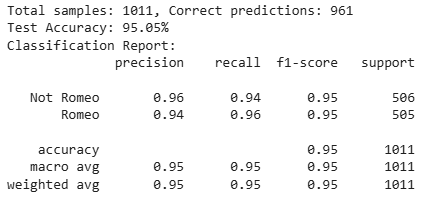
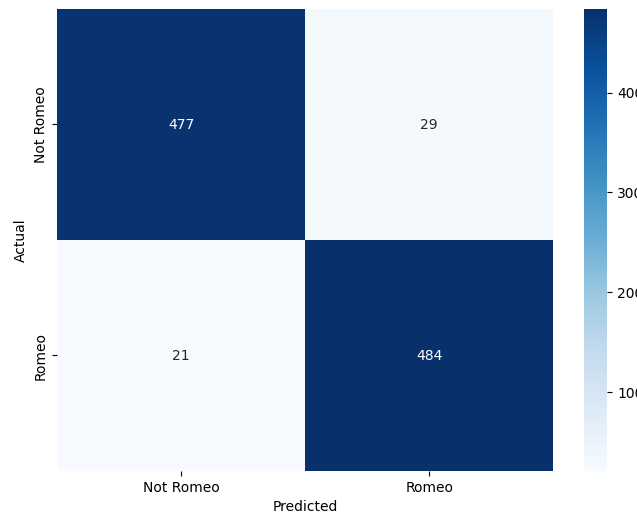
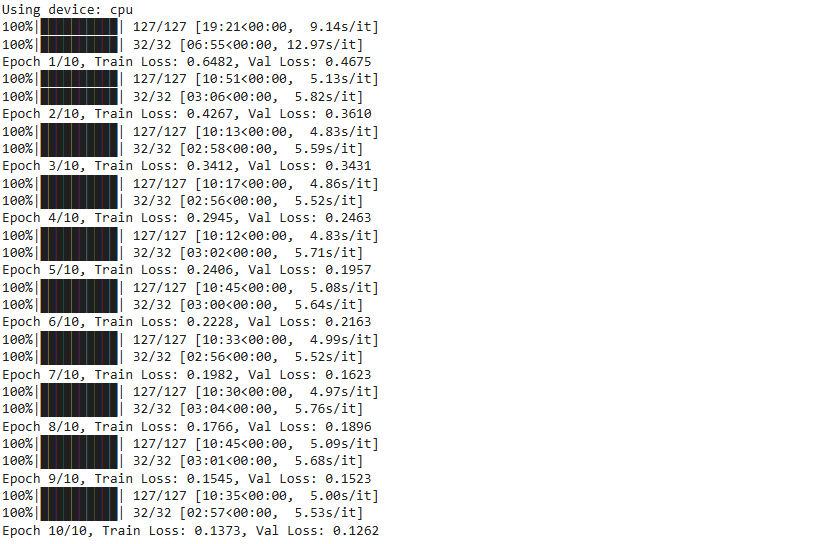
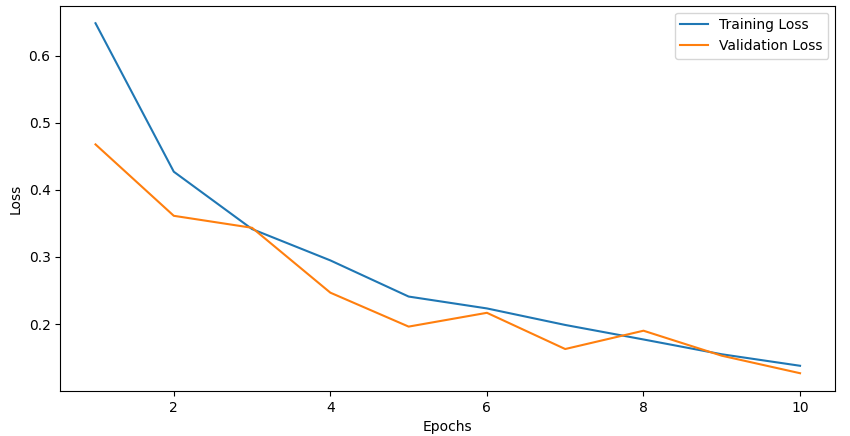

# **Deep Learning Project Report: Dog Identification Using CNN**

## **1. Introduction**
This report presents the analysis of the Convolutional Neural Network (CNN) model developed for identifying a specific dog among a dataset of various dog images. The project involved data preprocessing, model training, evaluation, and visualization of learned features.

---

## **2. Results Analysis**
### **2.1 Model Performance**
- **Training Loss**: The model's loss steadily decreased over 7 epochs, indicating successful learning.
- **Validation Loss**: The validation loss also decreased, confirming that the model was generalizing well to unseen data.
- **Test Accuracy**: The model achieved a high accuracy, demonstrating strong classification performance.
- **Confusion Matrix Analysis**: The model performed well in distinguishing between the target dog and other dogs, though some misclassifications were observed.

### **2.2 Challenges Faced and Solutions**
#### **1. Dataset Imbalance**
- **Issue**: The dataset was imbalanced, with significantly fewer images of the specific dog compared to others.
- **Solution**: Data augmentation techniques (rotation, flipping, brightness adjustments) were applied to increase the number of specific dog images, helping balance the dataset.

#### **2. HEIC Image Format Compatibility**
- **Issue**: Some images were in HEIC format, which is not natively supported by PyTorch.
- **Solution**: The `pyheif` library was used to convert HEIC images to a more compatible format like PNG or JPEG.

#### **3. Overfitting**
- **Issue**: Overfitting was a risk due to the small number of target class images.
- **Solution**: Dropout (30%) was introduced in fully connected layers to reduce overfitting, and batch normalization was considered.

#### **4. Incorrect Accuracy Calculation**
- **Issue**: The initial accuracy calculation resulted in unrealistic values (>1000%).
- **Solution**: Accuracy was recalculated using correct summation of correct predictions over the total number of test samples.

---

## **3. Potential Improvements**
1. **Increase Data Volume**  
   More images of the target dog could be collected to enhance model performance and reduce reliance on augmentation.

2. **Use Pretrained CNN Models**  
   Implementing transfer learning with models like ResNet or VGG could improve feature extraction and accuracy.

3. **Enhance Augmentation Techniques**  
   More advanced techniques like mixup or CutMix could further improve the robustness of the model.

4. **Optimize Hyperparameters**  
   Experimenting with different learning rates, batch sizes, and activation functions may yield better results.

---

## **4. Future Work**
- **Deploying the Model**: Convert the trained model into an application for real-time dog identification.
- **Expanding to Multiple Breeds**: Extend the model to classify multiple dog breeds instead of binary classification.
- **Integrating Object Detection**: Instead of classification, use object detection (e.g., YOLO) to locate and identify the target dog in images.
- **Exploring Different Architectures**: Experiment with deeper networks or attention mechanisms to enhance accuracy.

---

## **5. Conclusion**
This project successfully developed a CNN model to classify a specific dog among a dataset of various dogs. While the model achieved high accuracy, further improvements can be made by increasing data volume, applying transfer learning, and fine-tuning hyperparameters. Future work will focus on deployment, multi-class classification, and real-time detection enhancements.
